In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

### Functions declaration

In [5]:
def detrend_dim(da, dim, degree):
    # Store original attributes
    original_attrs = da.attrs

    # Detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = da - fit
    
    # Restore original attributes
    da_det.attrs = original_attrs
    
    return da_det

def xr_mean_list(xarray_list):
    # Step 1: Group the xarray objects by their "esm" attribute
    esm_groups = {}
    for xr_obj in xarray_list:
        esm_value = xr_obj.attrs.get('esm', None)
        if esm_value not in esm_groups:
            esm_groups[esm_value] = []
        esm_groups[esm_value].append(xr_obj)

    # Step 2: Sort the esm groups alphabetically by their esm value
    sorted_esm_values = sorted(esm_groups.keys())

    # Step 3: Calculate the mean for each group in alphabetical order
    mean_results = {}
    for esm_value in sorted_esm_values:
        xr_objs = esm_groups[esm_value]
        
        # Concatenate all xarray objects in this group along a new dimension (e.g., 'stacked_xarrays')
        combined = xr.concat(xr_objs, dim='stacked_xarrays')
        
        # Calculate the mean along the 'stacked_xarrays' dimension
        mean_results[esm_value] = combined.mean(dim='stacked_xarrays')
    
    return mean_results


## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    results = {}
    results["cor"] = cor
    results["coef"] = slope
    results["pval"] = pval
    return results

def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [6]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/figures/'

#out_path = "D:/Data/CMIP6/RESULTS"

# -- Create directories
checkDir(out_path)

### Open SST data

In [7]:
##### ------- Open data (MODEL) ------- #####
data_path = 'F:/Data/analysis/'
scenario = 'historical'
files = "nino34" + '_*_' + scenario + '_*_det.nc'

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)   

nino34_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_hist.append(content)

scenario = 'ssp585'
files = "nino34" + '_*_' + scenario + '_*_det.nc' 

nino34_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_ssp.append(content)

## Normalization
# for i,item in enumerate(nino34_hist):
#     nino34_hist[i] =  ((nino34_hist[i] - (nino34_hist[i].mean(dim='time'))).compute()/(nino34_hist[i].std(dim='time'))).compute()

# for i,item in enumerate(nino34_ssp):
#     nino34_ssp[i] =  ((nino34_ssp[i] - (nino34_ssp[i].mean(dim='time'))).compute()/(nino34_ssp[i].std(dim='time'))).compute()


## Resample from Monthly to seasonal timesteps
nino34_hist = [a.resample(time="Y", label='right').mean() for a in nino34_hist]
nino34_ssp = [a.resample(time="Y", label='right').mean() for a in nino34_ssp]

# Convert to dataarray
nino34_hist = [a.to_array() for a in nino34_hist]
nino34_ssp = [a.to_array() for a in nino34_ssp]

# Delete useless empty dimension
nino34_hist = [nino.squeeze().rename(variable = "tos").drop("tos") for nino in nino34_hist]
nino34_ssp = [nino.squeeze().rename(variable = "tos").drop("tos") for nino in nino34_ssp]

# Correct for spurious dimension
for i, item in enumerate(nino34_hist):
    if len(nino34_hist[i].shape)!=1:
        nino34_hist[i] = nino34_hist[i][1]
    else:
        None


### Open LAND data

In [8]:
data_path = 'F:/Data/analysis/'              

Rh

In [9]:
scenario = 'ssp585'
var_name = 'rh'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_rh = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_rh.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_rh):
    ds_ssp_rh[i] = ds_ssp_rh[i].isel(time = slice(0,1032))
    ds_ssp_rh[i] = ds_ssp_rh[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_rh[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_rh[i] = ds_ssp_rh[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_rh[i] = ds_ssp_rh[i].resample(time="Y", label='right').mean()

In [10]:
scenario = 'historical'
var_name = 'rh'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_rh = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_rh.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_rh):
    ds_hist_rh[i] = ds_hist_rh[i].isel(time = slice(0,1980))
    ds_hist_rh[i] = ds_hist_rh[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_rh[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_rh[i] = ds_hist_rh[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_rh[i] = ds_hist_rh[i].resample(time="Y", label='right').mean()

Ra

In [11]:
scenario = 'ssp585'
var_name = 'ra'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_ra = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_ra.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_ra):
    ds_ssp_ra[i] = ds_ssp_ra[i].isel(time = slice(0,1032))
    ds_ssp_ra[i] = ds_ssp_ra[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_ra[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_ra[i] = ds_ssp_ra[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_ra[i] = ds_ssp_ra[i].resample(time="Y", label='right').mean()

In [12]:
scenario = 'historical'
var_name = 'ra'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_ra = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_ra.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_ra):
    ds_hist_ra[i] = ds_hist_ra[i].isel(time = slice(0,1980))
    ds_hist_ra[i] = ds_hist_ra[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_ra[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_ra[i] = ds_hist_ra[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_ra[i] = ds_hist_ra[i].resample(time="Y", label='right').mean()

GPP

In [13]:
scenario = 'ssp585'
var_name = 'gpp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_gpp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_gpp):
    ds_ssp_gpp[i] = ds_ssp_gpp[i].isel(time = slice(0,1032))
    ds_ssp_gpp[i] = ds_ssp_gpp[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_gpp[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_gpp[i] = ds_ssp_gpp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_gpp[i] = ds_ssp_gpp[i].resample(time="Y", label='right').mean()

In [14]:
scenario = 'historical'
var_name = 'gpp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_gpp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_gpp):
    ds_hist_gpp[i] = ds_hist_gpp[i].isel(time = slice(0,1980))
    ds_hist_gpp[i] = ds_hist_gpp[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_gpp[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_gpp[i] = ds_hist_gpp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_gpp[i] = ds_hist_gpp[i].resample(time="Y", label='right').mean()

NEP

In [15]:
scenario = 'ssp585'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_nep.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_nep):
    ds_ssp_nep[i] = ds_ssp_nep[i].isel(time = slice(0,1032))
    ds_ssp_nep[i] = ds_ssp_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_nep[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_nep[i] = ds_ssp_nep[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_nep[i] = ds_ssp_nep[i].resample(time="Y", label='right').mean()

In [16]:
scenario = 'historical'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_nep.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_nep):
    ds_hist_nep[i] = ds_hist_nep[i].isel(time = slice(0,1980))
    ds_hist_nep[i] = ds_hist_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_nep[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_nep[i] = ds_hist_nep[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_nep[i] = ds_hist_nep[i].resample(time="Y", label='right').mean()

NBP

In [17]:
scenario = 'ssp585'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_nbp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_nbp):
    ds_ssp_nbp[i] = ds_ssp_nbp[i].isel(time = slice(0,1032))
    ds_ssp_nbp[i] = ds_ssp_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_nbp[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_nbp[i] = ds_ssp_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_nbp[i] = ds_ssp_nbp[i].resample(time="Y", label='right').mean()

In [18]:
scenario = 'historical'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_nbp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_nbp):
    ds_hist_nbp[i] = ds_hist_nbp[i].isel(time = slice(0,1980))
    ds_hist_nbp[i] = ds_hist_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_nbp[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_nbp[i] = ds_hist_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_nbp[i] = ds_hist_nbp[i].resample(time="Y", label='right').mean()

Temperature

In [19]:
scenario = 'ssp585'
var_name = 'tas'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_tas.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_tas):
    ds_ssp_tas[i] = ds_ssp_tas[i].isel(time = slice(0,1032))
    ds_ssp_tas[i] = ds_ssp_tas[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_tas[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_tas[i] = ds_ssp_tas[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_tas[i] = ds_ssp_tas[i].resample(time="Y", label='right').mean()
    if "height" in ds_ssp_tas[i].coords:
        ds_ssp_tas[i] = ds_ssp_tas[i].drop_vars("height")

In [20]:
scenario = 'historical'
var_name = 'tas'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_tas.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_tas):
    ds_hist_tas[i] = ds_hist_tas[i].isel(time = slice(0,1980))
    ds_hist_tas[i] = ds_hist_tas[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_tas[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_tas[i] = ds_hist_tas[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_tas[i] = ds_hist_tas[i].resample(time="Y", label='right').mean()

Precipitation

In [21]:
scenario = 'ssp585'
var_name = 'pr'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_pr.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_pr):
    ds_ssp_pr[i] = ds_ssp_pr[i].isel(time = slice(0,1032))
    ds_ssp_pr[i] = ds_ssp_pr[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_pr[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_pr[i] = ds_ssp_pr[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_pr[i] = ds_ssp_pr[i].resample(time="Y", label='right').sum()


In [22]:
scenario = 'historical'
var_name = 'pr'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_pr.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_pr):
    ds_hist_pr[i] = ds_hist_pr[i].isel(time = slice(0,1980))
    ds_hist_pr[i] = ds_hist_pr[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_pr[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_pr[i] = ds_hist_pr[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_pr[i] = ds_hist_pr[i].resample(time="Y", label='right').mean()

Soil Moisture

In [23]:
data_path = 'F:/Data/analysis/'              

scenario = 'ssp585'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_mrso.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_mrso):
    ds_ssp_mrso[i] = ds_ssp_mrso[i].isel(time = slice(0,1032))
    ds_ssp_mrso[i] = ds_ssp_mrso[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_mrso[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_mrso[i] = ds_ssp_mrso[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_mrso[i] = ds_ssp_mrso[i].resample(time="Y", label='right').mean()


In [24]:
scenario = 'historical'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_mrso.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_mrso):
    ds_hist_mrso[i] = ds_hist_mrso[i].isel(time = slice(0,1980))
    ds_hist_mrso[i] = ds_hist_mrso[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_mrso[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_mrso[i] = ds_hist_mrso[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_mrso[i] = ds_hist_mrso[i].resample(time="Y", label='right').mean()

SWin

In [25]:
scenario = 'ssp585'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_rsds.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_rsds):
    ds_ssp_rsds[i] = ds_ssp_rsds[i].isel(time = slice(0,1032))
    ds_ssp_rsds[i] = ds_ssp_rsds[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_rsds[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_rsds[i] = ds_ssp_rsds[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_rsds[i] = ds_ssp_rsds[i].resample(time="Y", label='right').mean()


In [26]:
scenario = 'historical'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_rsds.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_rsds):
    ds_hist_rsds[i] = ds_hist_rsds[i].isel(time = slice(0,1980))
    ds_hist_rsds[i] = ds_hist_rsds[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_rsds[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_rsds[i] = ds_hist_rsds[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_rsds[i] = ds_hist_rsds[i].resample(time="Y", label='right').mean()

Relative humidity

In [27]:
scenario = 'ssp585'
var_name = 'hurs'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_hurs = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_hurs.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_hurs):
    ds_ssp_hurs[i] = ds_ssp_hurs[i].isel(time = slice(0,1032))
    ds_ssp_hurs[i] = ds_ssp_hurs[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_hurs[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_hurs[i] = ds_ssp_hurs[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_hurs[i] = ds_ssp_hurs[i].resample(time="Y", label='right').mean()
    if "height" in ds_ssp_hurs[i].coords:
        ds_ssp_hurs[i] = ds_ssp_hurs[i].drop_vars("height")


In [28]:
scenario = 'historical'
var_name = 'hurs'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_hurs = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_hurs.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_hurs):
    ds_hist_hurs[i] = ds_hist_hurs[i].isel(time = slice(0,1980))
    ds_hist_hurs[i] = ds_hist_hurs[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_hurs[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_hurs[i] = ds_hist_hurs[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_hurs[i] = ds_hist_hurs[i].resample(time="Y", label='right').mean()

Correct UKESM lon numbers

In [29]:
ds_hist_nep[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_nep[37:40]]
ds_hist_mrso[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_mrso[37:40]]
ds_hist_tas[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_tas[37:40]]
ds_hist_rsds[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_rsds[37:40]]
ds_hist_pr[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_pr[37:40]]
ds_hist_hurs[37:40] = [a.isel(lon = slice(0,191)) for a in ds_hist_hurs[37:40]]

ds_ssp_nep[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_nep[37:40]]
ds_ssp_mrso[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_mrso[37:40]]
ds_ssp_tas[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_tas[37:40]]
ds_ssp_rsds[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_rsds[37:40]]
ds_ssp_pr[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_pr[37:40]]
ds_ssp_hurs[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_hurs[37:40]]

### Calculate VPD

In [30]:
import math

def calculate_vpd(rh, tas, unit):
    """
    Input: Relative Humidity and Air Temperature 
    Output: Vapour Pressure Deficit (VPD), in kPa
    
    Parameters:
    rh : Relative Humidity in %
    tas : Air temperature in Kelvin or Celsius
    unit : 'Kelvin' or 'Celsius'
    """
    original_attrs = tas.attrs
    # Convert temperature to Celsius if given in Kelvin
    if unit == "Kelvin":
        tas_celsius = tas - 273.15
    elif unit == "Celsius":
        tas_celsius = tas
    else:
        raise ValueError("Insert correct Unit of Measure for Temperature: 'Kelvin' or 'Celsius'")
    
    # Calculate Saturation Vapour Pressure (SVP) in kPa
    svp = 0.61078 * np.exp((17.27 * tas_celsius) / (tas_celsius + 237.3))
    # Calculate Vapour Pressure Deficit (VPD) in kPa
    vpd = svp * (1 - rh / 100)
    vpd = vpd.assign_attrs(original_attrs)
    vpd = vpd.assign_attrs(unit = "kPa")

    return vpd

In [31]:
ds_hist_vpd = []; ds_ssp_vpd = []
for i, item in enumerate(ds_hist_hurs):
    content = calculate_vpd(ds_hist_hurs[i], ds_hist_tas[i], "Celsius")
    content1 = calculate_vpd(ds_ssp_hurs[i], ds_ssp_tas[i], "Celsius")

    ds_hist_vpd.append(content)
    ds_ssp_vpd.append(content1)

In [32]:
del ds_hist_hurs
del ds_ssp_hurs

### Correct for lon lat mishape and values

In [33]:
# Correct the number of longitude points
ds_hist_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_nep, ds_hist_vpd)]
ds_hist_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_mrso, ds_hist_vpd)]
ds_hist_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_tas, ds_hist_vpd)]
ds_hist_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_rsds, ds_hist_vpd)]
ds_hist_pr = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_pr, ds_hist_vpd)]
ds_ssp_vpd = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_vpd, ds_ssp_pr)]
ds_ssp_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_rsds, ds_ssp_pr)]
ds_ssp_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_nep, ds_ssp_pr)]
ds_ssp_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_mrso, ds_ssp_pr)]
ds_ssp_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_tas, ds_ssp_pr)]
ds_hist_gpp = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_gpp, ds_hist_vpd)]
ds_ssp_gpp = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_gpp, ds_ssp_pr)]
ds_hist_ra = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_ra, ds_hist_vpd)]
ds_ssp_ra = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_ra, ds_ssp_pr)]
ds_hist_rh = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_rh, ds_hist_vpd)]
ds_ssp_rh = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_rh, ds_ssp_pr)]


# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_hist_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_pr,ds_hist_nep)]
ds_hist_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_tas,ds_hist_nep)]
ds_hist_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_mrso,ds_hist_nep)]
ds_hist_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_rsds,ds_hist_nep)]
ds_hist_vpd = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_vpd,ds_hist_nep)]
ds_ssp_vpd = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_vpd,ds_ssp_nep)]
ds_ssp_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_rsds,ds_ssp_nep)]
ds_ssp_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_pr,ds_ssp_nep)]
ds_ssp_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_tas,ds_ssp_nep)]
ds_ssp_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_mrso,ds_ssp_nep)]
ds_hist_gpp = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_gpp,ds_hist_nep)]
ds_ssp_gpp = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_gpp,ds_ssp_nep)]
ds_hist_ra = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_ra,ds_hist_nep)]
ds_ssp_ra = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_ra,ds_ssp_nep)]
ds_hist_rh = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_rh,ds_hist_nep)]
ds_ssp_rh = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_rh,ds_ssp_nep)]

In [34]:
esm_list = []
for i,item in enumerate(ds_ssp_nbp):
    esm_list.append(item.esm)

esm = sorted(list(set(esm_list)))

### Linear detrending

In [35]:
# Detrending of 1st order
ds_hist_nep = [detrend_dim(a, "time", 1) for a in ds_hist_nep]
ds_hist_gpp = [detrend_dim(a, "time", 1) for a in ds_hist_gpp]
ds_hist_ra = [detrend_dim(a, "time", 1) for a in ds_hist_ra]
ds_hist_rh = [detrend_dim(a, "time", 1) for a in ds_hist_rh]
ds_hist_nbp = [detrend_dim(a, "time", 1) for a in ds_hist_nbp]
ds_hist_tas = [detrend_dim(a, "time", 1) for a in ds_hist_tas]
ds_hist_pr = [detrend_dim(a, "time", 1) for a in ds_hist_pr]
ds_hist_mrso = [detrend_dim(a, "time", 1) for a in ds_hist_mrso]
ds_hist_rsds = [detrend_dim(a, "time", 1) for a in ds_hist_rsds]
ds_hist_vpd = [detrend_dim(a, "time", 1) for a in ds_hist_vpd]

In [36]:
# Detrending of 1st order
ds_ssp_nep = [detrend_dim(a, "time", 1) for a in ds_ssp_nep]
ds_ssp_gpp = [detrend_dim(a, "time", 1) for a in ds_ssp_gpp]
ds_ssp_ra = [detrend_dim(a, "time", 1) for a in ds_ssp_ra]
ds_ssp_rh = [detrend_dim(a, "time", 1) for a in ds_ssp_rh]
ds_ssp_nbp = [detrend_dim(a, "time", 1) for a in ds_ssp_nbp]
ds_ssp_tas = [detrend_dim(a, "time", 1) for a in ds_ssp_tas]
ds_ssp_pr = [detrend_dim(a, "time", 1) for a in ds_ssp_pr]
ds_ssp_mrso = [detrend_dim(a, "time", 1) for a in ds_ssp_mrso]
ds_ssp_rsds = [detrend_dim(a, "time", 1) for a in ds_ssp_rsds]
ds_ssp_vpd = [detrend_dim(a, "time", 1) for a in ds_ssp_vpd]

## Univariate regression

### T and SM Sensitivity to ENSO

In [37]:
dPrdn34_hist = []
dTdn34_hist = []
dSMdn34_hist = []
drsdsdn34_hist = []
dVPDdn34_hist = []
for i, item in enumerate(ds_hist_nbp):

    content = lag_linregress_3D(nino34_hist[i],ds_hist_pr[i])
    content1 = lag_linregress_3D(nino34_hist[i],(ds_hist_tas[i] - ds_hist_tas[i].mean(dim = "time"))/ds_hist_tas[i].std(dim = "time"))
    content2 = lag_linregress_3D(nino34_hist[i],(ds_hist_mrso[i] - ds_hist_mrso[i].mean(dim = "time"))/ds_hist_mrso[i].std(dim = "time"))
    content3 = lag_linregress_3D(nino34_hist[i],ds_hist_rsds[i])
    content4 = lag_linregress_3D(nino34_hist[i],ds_hist_vpd[i])

    dPrdn34_hist.append(content)
    dTdn34_hist.append(content1)
    dSMdn34_hist.append(content2)
    drsdsdn34_hist.append(content3)
    dVPDdn34_hist.append(content4)


dPrdn34_ssp = []
dTdn34_ssp = []
dSMdn34_ssp = []
drsdsdn34_ssp = []
dVPDdn34_ssp = []
for i, item in enumerate(ds_ssp_nbp):

    content = lag_linregress_3D(nino34_ssp[i],ds_ssp_pr[i])
    content1 = lag_linregress_3D(nino34_ssp[i],(ds_ssp_tas[i] - ds_ssp_tas[i].mean(dim = "time"))/ds_ssp_tas[i].std(dim = "time"))
    content2 = lag_linregress_3D(nino34_ssp[i],(ds_ssp_mrso[i] - ds_ssp_mrso[i].mean(dim = "time"))/ds_ssp_mrso[i].std(dim = "time"))
    content3 = lag_linregress_3D(nino34_ssp[i],ds_ssp_rsds[i])
    content4 = lag_linregress_3D(nino34_ssp[i],ds_ssp_vpd[i])

    dPrdn34_ssp.append(content)
    dTdn34_ssp.append(content1)
    dSMdn34_ssp.append(content2)
    drsdsdn34_ssp.append(content3)
    dVPDdn34_ssp.append(content4)

### NBP sensitivity to T and SM

In [38]:
# Standardized predictors

dnbpdPr_hist = []
dnbpdT_hist = []
dnbpdSM_hist = []
dnbpdrsds_hist = []
dnbpdVPD_hist = []
for i, item in enumerate(ds_hist_nbp):

    content = lag_linregress_3D((ds_hist_pr[i] - ds_hist_pr[i].mean(dim = "time"))/ds_hist_pr[i].std(dim = "time"), ds_hist_nbp[i])["coef"]
    content1 = lag_linregress_3D((ds_hist_tas[i] - ds_hist_tas[i].mean(dim = "time"))/ds_hist_tas[i].std(dim = "time"), ds_hist_nbp[i])["coef"]
    content2 = lag_linregress_3D((ds_hist_mrso[i] - ds_hist_mrso[i].mean(dim = "time"))/ds_hist_mrso[i].std(dim = "time"), ds_hist_nbp[i])["coef"]
    content3 = lag_linregress_3D((ds_hist_rsds[i] - ds_hist_rsds[i].mean(dim = "time"))/ds_hist_rsds[i].std(dim = "time"), ds_hist_nbp[i])["coef"]
    content4 = lag_linregress_3D((ds_hist_vpd[i] - ds_hist_vpd[i].mean(dim = "time"))/ds_hist_vpd[i].std(dim = "time"), ds_hist_nbp[i])["coef"]

    dnbpdPr_hist.append(content)
    dnbpdT_hist.append(content1)
    dnbpdSM_hist.append(content2)
    dnbpdrsds_hist.append(content3)
    dnbpdVPD_hist.append(content4)

dnbpdPr_ssp = []
dnbpdT_ssp = []
dnbpdSM_ssp = []
dnbpdrsds_ssp = []
dnbpdVPD_ssp = []
for i, item in enumerate(ds_ssp_nbp):

    content = lag_linregress_3D((ds_ssp_pr[i] - ds_ssp_pr[i].mean(dim = "time"))/ds_ssp_pr[i].std(dim = "time"), ds_ssp_nbp[i])["coef"]
    content1 = lag_linregress_3D((ds_ssp_tas[i] - ds_ssp_tas[i].mean(dim = "time"))/ds_ssp_tas[i].std(dim = "time"), ds_ssp_nbp[i])["coef"]
    content2 = lag_linregress_3D((ds_ssp_mrso[i] - ds_ssp_mrso[i].mean(dim = "time"))/ds_ssp_mrso[i].std(dim = "time"), ds_ssp_nbp[i])["coef"]
    content3 = lag_linregress_3D((ds_ssp_rsds[i] - ds_ssp_rsds[i].mean(dim = "time"))/ds_ssp_rsds[i].std(dim = "time"), ds_ssp_nbp[i])["coef"]
    content4 = lag_linregress_3D((ds_ssp_vpd[i] - ds_ssp_vpd[i].mean(dim = "time"))/ds_ssp_vpd[i].std(dim = "time"), ds_ssp_nbp[i])["coef"]

    dnbpdPr_ssp.append(content)
    dnbpdT_ssp.append(content1)
    dnbpdSM_ssp.append(content2)
    dnbpdrsds_ssp.append(content3)
    dnbpdVPD_ssp.append(content4)

### dNBP/dT and dNBP/dSM

In [39]:
Snbp_pr_hist = []
Snbp_tas_hist = []
Snbp_mrso_hist = []
Snbp_rsds_hist = []
Snbp_vpd_hist = []
for i, item in enumerate(ds_hist_nbp):

    content = dnbpdPr_hist[i] * dPrdn34_hist[i]["coef"]
    content1 = dnbpdT_hist[i] * dTdn34_hist[i]["coef"]
    content2 = dnbpdSM_hist[i] * dSMdn34_hist[i]["coef"]
    content3 = dnbpdrsds_hist[i] * drsdsdn34_hist[i]["coef"]
    content4 = dnbpdVPD_hist[i] * dVPDdn34_hist[i]["coef"]

    Snbp_pr_hist.append(content)
    Snbp_tas_hist.append(content1)
    Snbp_mrso_hist.append(content2)
    Snbp_rsds_hist.append(content3)
    Snbp_vpd_hist.append(content4)

Snbp_pr_ssp = []
Snbp_tas_ssp = []
Snbp_mrso_ssp = []
Snbp_rsds_ssp = []
Snbp_vpd_ssp = []
for i, item in enumerate(ds_ssp_nbp):

    content = dnbpdPr_ssp[i] * dPrdn34_ssp[i]["coef"]
    content1 = dnbpdT_ssp[i] * dTdn34_ssp[i]["coef"]
    content2 = dnbpdSM_ssp[i] * dSMdn34_ssp[i]["coef"]
    content3 = dnbpdrsds_ssp[i] * drsdsdn34_ssp[i]["coef"]
    content4 = dnbpdVPD_ssp[i] * dVPDdn34_ssp[i]["coef"]

    Snbp_pr_ssp.append(content)
    Snbp_tas_ssp.append(content1)
    Snbp_mrso_ssp.append(content2)
    Snbp_rsds_ssp.append(content3)
    Snbp_vpd_ssp.append(content4)

## Ridge Regression

### import RR partial coefficients

In [40]:
import pickle
data_path = 'G:/My Drive/Amazon_CMIP6/results/regression/'

# NBP
with open(os.path.join(data_path+"mlr_iav_nbp_hist_coef_std_noenso"), "rb") as fp:   #Pickling
    coef_nbp_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_nbp_ssp_coef_std_noenso"), "rb") as fp:   #Pickling
    coef_nbp_ssp = pickle.load(fp)

with open(os.path.join(data_path+"mlr_iav_nbp_hist_ypred_noenso"), "rb") as fp:   #Pickling
    pred_nbp_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_nbp_ssp_ypred_noenso"), "rb") as fp:   #Pickling
    pred_nbp_ssp = pickle.load(fp)


FileNotFoundError: [Errno 2] No such file or directory: 'G:/My Drive/Amazon_CMIP6/results/regression/mlr_iav_nbp_hist_coef_std_noenso'

In [ ]:
# Assign ESM attributes
for i, mm in enumerate(ds_hist_nbp):
    coef_nbp_hist[i] = coef_nbp_hist[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    coef_nbp_ssp[i] = coef_nbp_ssp[i].assign_attrs(esm = ds_ssp_nbp[i].esm)
    pred_nbp_hist[i] = pred_nbp_hist[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    pred_nbp_ssp[i] = pred_nbp_ssp[i].assign_attrs(esm = ds_ssp_nbp[i].esm)


In [ ]:
Rnbp_tas_hist = []
Rnbp_mrso_hist = []
Rnbp_rsds_hist = []
for i, item in enumerate(ds_hist_nbp):

    content1 = coef_nbp_hist[i].tas * dTdn34_hist[i]["coef"]
    content2 = coef_nbp_hist[i].mrso * dSMdn34_hist[i]["coef"]
    content3 = coef_nbp_hist[i].rsds * drsdsdn34_hist[i]["coef"]

    Rnbp_tas_hist.append(content1)
    Rnbp_mrso_hist.append(content2)
    Rnbp_rsds_hist.append(content3)

Rnbp_tas_ssp = []
Rnbp_mrso_ssp = []
Rnbp_rsds_ssp = []
for i, item in enumerate(ds_ssp_nbp):

    content1 = coef_nbp_ssp[i].tas * dTdn34_ssp[i]["coef"]
    content2 = coef_nbp_ssp[i].mrso * dSMdn34_ssp[i]["coef"]
    content3 = coef_nbp_ssp[i].rsds * drsdsdn34_ssp[i]["coef"]

    Rnbp_tas_ssp.append(content1)
    Rnbp_mrso_ssp.append(content2)
    Rnbp_rsds_ssp.append(content3)


## Amazon mask

In [ ]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    attrs = ds.attrs
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean()
    ds_z.assign_attrs(attrs)
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

### Univariate ENSO-mediated sensitivity


In [ ]:
Sn34_hist_amz = []

for m,mm in enumerate(ds_hist_nbp):
    final = pd.DataFrame()
    content = mask_shape(dPrdn34_hist[m]["coef"], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "pr_n34").drop(columns = ["lon", "lat", "region"])
    content1 = mask_shape(dTdn34_hist[m]["coef"], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "tas_n34").drop(columns = ["lon", "lat", "region"])    
    content2 = mask_shape(dSMdn34_hist[m]["coef"], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "mrso_n34").drop(columns = ["lon", "lat", "region"])    
    content3 = mask_shape(drsdsdn34_hist[m]["coef"], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "rsds_n34").drop(columns = ["lon", "lat", "region"])   
    content4 = mask_shape(dVPDdn34_hist[m]["coef"], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "vpd_n34").drop(columns = ["lon", "lat", "region"]) 

    final = pd.concat([content.reset_index().drop(columns = ["lon", "lat"]),content1.reset_index().drop(columns = ["lon", "lat"]),
                content2.reset_index().drop(columns = ["lon", "lat"]),content3.reset_index().drop(columns = ["lon", "lat"]),
                content4.reset_index().drop(columns = ["lon", "lat"])], axis = 1)

    if "height" in final.columns:            
        final = final.drop(columns = "height")

    Sn34_hist_amz.append(final)

In [ ]:
Sn34_ssp_amz = []

for m,mm in enumerate(ds_ssp_nbp):
    final = pd.DataFrame()
    content = mask_shape(dPrdn34_ssp[m]["coef"], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "pr_n34").drop(columns = ["lon", "lat", "region"])
    content1 = mask_shape(dTdn34_ssp[m]["coef"], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "tas_n34").drop(columns = ["lon", "lat", "region"])    
    content2 = mask_shape(dSMdn34_ssp[m]["coef"], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "mrso_n34").drop(columns = ["lon", "lat", "region"])    
    content3 = mask_shape(drsdsdn34_ssp[m]["coef"], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "rsds_n34").drop(columns = ["lon", "lat", "region"])   
    content4 = mask_shape(dVPDdn34_ssp[m]["coef"], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "vpd_n34").drop(columns = ["lon", "lat", "region"]) 

    final = pd.concat([content.reset_index().drop(columns = ["lon", "lat"]),content1.reset_index().drop(columns = ["lon", "lat"]),
                content2.reset_index().drop(columns = ["lon", "lat"]),content3.reset_index().drop(columns = ["lon", "lat"]),
                content4.reset_index().drop(columns = ["lon", "lat"])], axis = 1)

    if "height" in final.columns:            
        final = final.drop(columns = "height")

    Sn34_ssp_amz.append(final)

In [ ]:
Snbp_hist_amz = []

for m,mm in enumerate(ds_hist_nbp):
    final = pd.DataFrame()
    content = mask_shape(Snbp_pr_hist[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_pr").drop(columns = ["lon", "lat", "region"])
    content1 = mask_shape(Snbp_tas_hist[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_tas").drop(columns = ["lon", "lat", "region"])    
    content2 = mask_shape(Snbp_mrso_hist[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_mrso").drop(columns = ["lon", "lat", "region"])    
    content3 = mask_shape(Snbp_rsds_hist[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_rsds").drop(columns = ["lon", "lat", "region"])   
    content4 = mask_shape(Snbp_vpd_hist[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_vpd").drop(columns = ["lon", "lat", "region"]) 

    final = pd.concat([content.reset_index().drop(columns = ["lon", "lat"]),content1.reset_index().drop(columns = ["lon", "lat"]),
                content2.reset_index().drop(columns = ["lon", "lat"]),content3.reset_index().drop(columns = ["lon", "lat"]),
                content4.reset_index().drop(columns = ["lon", "lat"])], axis = 1)

    if "height" in final.columns:            
        final = final.drop(columns = "height")

    Snbp_hist_amz.append(final)

In [ ]:
Snbp_ssp_amz = []

for m,mm in enumerate(ds_ssp_nbp):
    final = pd.DataFrame()
    content = mask_shape(Snbp_pr_ssp[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_pr").drop(columns = ["lon", "lat", "region"])
    content1 = mask_shape(Snbp_tas_ssp[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_tas").drop(columns = ["lon", "lat", "region"])    
    content2 = mask_shape(Snbp_mrso_ssp[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_mrso").drop(columns = ["lon", "lat", "region"])    
    content3 = mask_shape(Snbp_rsds_ssp[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_rsds").drop(columns = ["lon", "lat", "region"])   
    content4 = mask_shape(Snbp_vpd_ssp[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_vpd").drop(columns = ["lon", "lat", "region"]) 

    final = pd.concat([content.reset_index().drop(columns = ["lon", "lat"]),content1.reset_index().drop(columns = ["lon", "lat"]),
                content2.reset_index().drop(columns = ["lon", "lat"]),content3.reset_index().drop(columns = ["lon", "lat"]),
                content4.reset_index().drop(columns = ["lon", "lat"])], axis = 1)

    if "height" in final.columns:
        final = final.drop(columns = "height")

    Snbp_ssp_amz.append(final)


### Bivariate ENSO-mediated sensitivity

In [ ]:
Rnbp_hist_amz = []

for m,mm in enumerate(ds_hist_nbp):
    final = pd.DataFrame()
    content1 = mask_shape(Rnbp_tas_hist[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_tas").drop(columns = ["lon", "lat", "region"])    
    content2 = mask_shape(Rnbp_mrso_hist[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_mrso").drop(columns = ["lon", "lat", "region"])    
    content3 = mask_shape(Rnbp_rsds_hist[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_rsds").drop(columns = ["lon", "lat", "region"])   

    final = pd.concat([content1.reset_index().drop(columns = ["lon", "lat"]),
                content2.reset_index().drop(columns = ["lon", "lat"]),content3.reset_index().drop(columns = ["lon", "lat"])], axis = 1)

    if "height" in final.columns:            
        final = final.drop(columns = "height")

    Rnbp_hist_amz.append(final)

In [ ]:
Rnbp_ssp_amz = []

for m,mm in enumerate(ds_ssp_nbp):
    final = pd.DataFrame()
    content1 = mask_shape(Rnbp_tas_ssp[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_tas").drop(columns = ["lon", "lat", "region"])    
    content2 = mask_shape(Rnbp_mrso_ssp[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_mrso").drop(columns = ["lon", "lat", "region"])    
    content3 = mask_shape(Rnbp_rsds_ssp[m], geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_rsds").drop(columns = ["lon", "lat", "region"])   

    final = pd.concat([content1.reset_index().drop(columns = ["lon", "lat"]),
                content2.reset_index().drop(columns = ["lon", "lat"]),content3.reset_index().drop(columns = ["lon", "lat"])], axis = 1)

    if "height" in final.columns:            
        final = final.drop(columns = "height")

    Rnbp_ssp_amz.append(final)

In [ ]:
import pandas as pd

def df_mean_list(df_list, esm_list):
    """
    Calculate the index-wise mean of DataFrames grouped by 'esm' values.

    Parameters:
    - df_list: List of pandas DataFrames to process.
    - esm_list: List of 'esm' values corresponding to each DataFrame.

    Returns:
    - A dictionary where keys are unique 'esm' values (sorted alphabetically),
      and values are DataFrames with the index-wise mean for the group.
    """
    # Step 1: Group the DataFrames by their esm values
    esm_groups = {}
    for df, esm in zip(df_list, esm_list):
        if esm not in esm_groups:
            esm_groups[esm] = []
        esm_groups[esm].append(df)

    # Step 2: Sort the esm groups alphabetically
    sorted_esm_values = sorted(esm_groups.keys())

    # Step 3: Calculate the mean for each group index-wise
    mean_results = {}
    for esm in sorted_esm_values:
        # Combine all DataFrames in this group along a new dimension
        group = esm_groups[esm]
        
        # Calculate index-wise mean
        combined = pd.concat(group, axis=1)  # Concatenate along columns
        mean_results[esm] = combined.groupby(by=combined.columns, axis=1).mean()     # Mean across DataFrames for each index
    
    return mean_results


In [ ]:
Sn34_hist_amz = df_mean_list(Sn34_hist_amz, esm_list)
Sn34_ssp_amz = df_mean_list(Sn34_ssp_amz, esm_list)

Sn34_amz = {}
for k in Sn34_hist_amz.keys(): 
    a = pd.melt(Sn34_hist_amz[k]); a["scenario"] = "hist"
    b = pd.melt(Sn34_ssp_amz[k]); b["scenario"] = "ssp"
    Sn34_amz[k] = pd.concat([a,b], axis = 0)
    # Obtain the inverse of Soil Moisture sensitivity to ENSO
    condition = Sn34_amz[k]["variable"] == "mrso_n34"
    Sn34_amz[k].loc[condition, "value"] *= -1

In [ ]:
Snbp_hist_amz = df_mean_list(Snbp_hist_amz, esm_list)
Snbp_ssp_amz = df_mean_list(Snbp_ssp_amz, esm_list)

Snbp_amz = {}
for k in Snbp_hist_amz.keys(): 
    a = pd.melt(Snbp_hist_amz[k]); a["scenario"] = "hist"
    b = pd.melt(Snbp_ssp_amz[k]); b["scenario"] = "ssp"
    Snbp_amz[k] = pd.concat([a,b], axis = 0)


In [ ]:
Rnbp_hist_amz = df_mean_list(Rnbp_hist_amz, esm_list)
Rnbp_ssp_amz = df_mean_list(Rnbp_ssp_amz, esm_list)

Rnbp_amz = {}
for k in Rnbp_hist_amz.keys(): 
    a = pd.melt(Rnbp_hist_amz[k]); a["scenario"] = "hist"
    b = pd.melt(Rnbp_ssp_amz[k]); b["scenario"] = "ssp"
    Rnbp_amz[k] = pd.concat([a,b], axis = 0)


### Plots

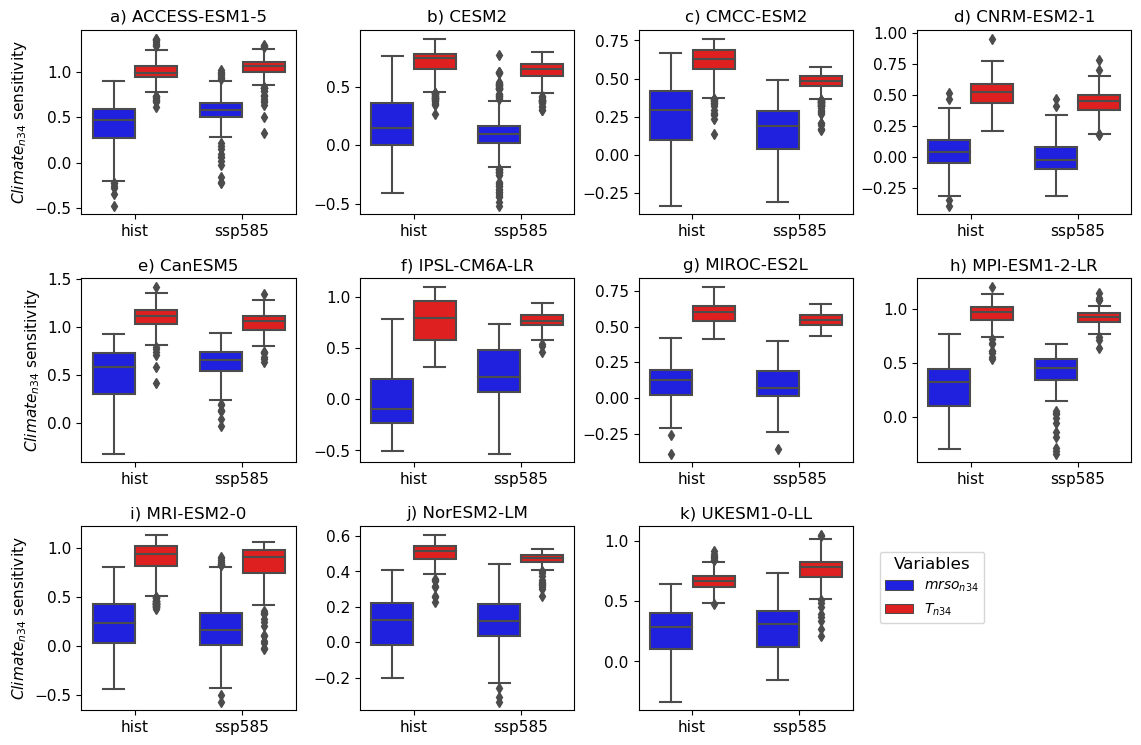

In [ ]:
import seaborn as sns
from matplotlib import gridspec
import os
import matplotlib.pyplot as plt

# Set figure dimensions
width_inch = 14
height_inch = 8

fig = plt.figure(figsize=(width_inch, height_inch))
gs = gridspec.GridSpec(3, 4)
panels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) ", "g) ", "h) ", "i) ", "j) ", "k) "]

# Loop through each model (esm)
for m, mm in enumerate(esm):
    df = Sn34_amz[mm]
    df = df.loc[(df["variable"] == "mrso_n34") | (df["variable"] == "tas_n34")]

    # Set subplot positions
    if m < 4:
        axs = fig.add_subplot(gs[0, m])  # First row
    elif 4 <= m < 8:
        axs = fig.add_subplot(gs[1, m-4])  # Second row
    else:
        axs = fig.add_subplot(gs[2, m-8])  # Third row

    # Plot the boxplot
    axs = sns.boxplot(data=df, x='scenario', y='value', hue='variable', palette=['blue', 'red'], ax=axs)
    axs.legend_.remove()  # Remove individual legends for subplots
    axs.set_xlabel("")
    axs.set_xticklabels(labels=["hist", "ssp585"])
    axs.tick_params(labelsize=11)
    axs.set_title(panels[m] + esm[m], y=1)

    # Set Y-labels for specific panels
    if m == 0 or m == 4:
        axs.set_ylabel("$Climate_{n34}$ sensitivity", fontsize=11)
    elif m == 8:
        axs.set_ylabel("$Climate_{n34}$ sensitivity", fontsize=11)
    else:
        axs.set_ylabel("")

# Adjust the spacing between subplots
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.15, right=0.9, wspace=0.3, hspace=0.35)

# Dynamically retrieve handles and labels for the legend
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, ["$mrso_{n34}$", "$T_{n34}$"], loc="lower right", fontsize=10, title="Variables", title_fontsize=12, bbox_to_anchor = (.8, .2))

# Add a title and save the output
title = "dClimate_dN34_boxplot"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)
fig.savefig(os.path.join(out_path, title + ".pdf"), bbox_inches='tight', dpi = 400)

plt.show()
plt.close()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

nbp_tas_hist v.s. nbp_tas_ssp: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.521e-23 U_stat=4.544e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

nbp_mrso_hist v.s. nbp_mrso_ssp: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.860e-16 U_stat=4.283e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

nbp_tas_hist v.s. nbp_tas_ssp: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.044e-20 U_stat=1.544e+05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1

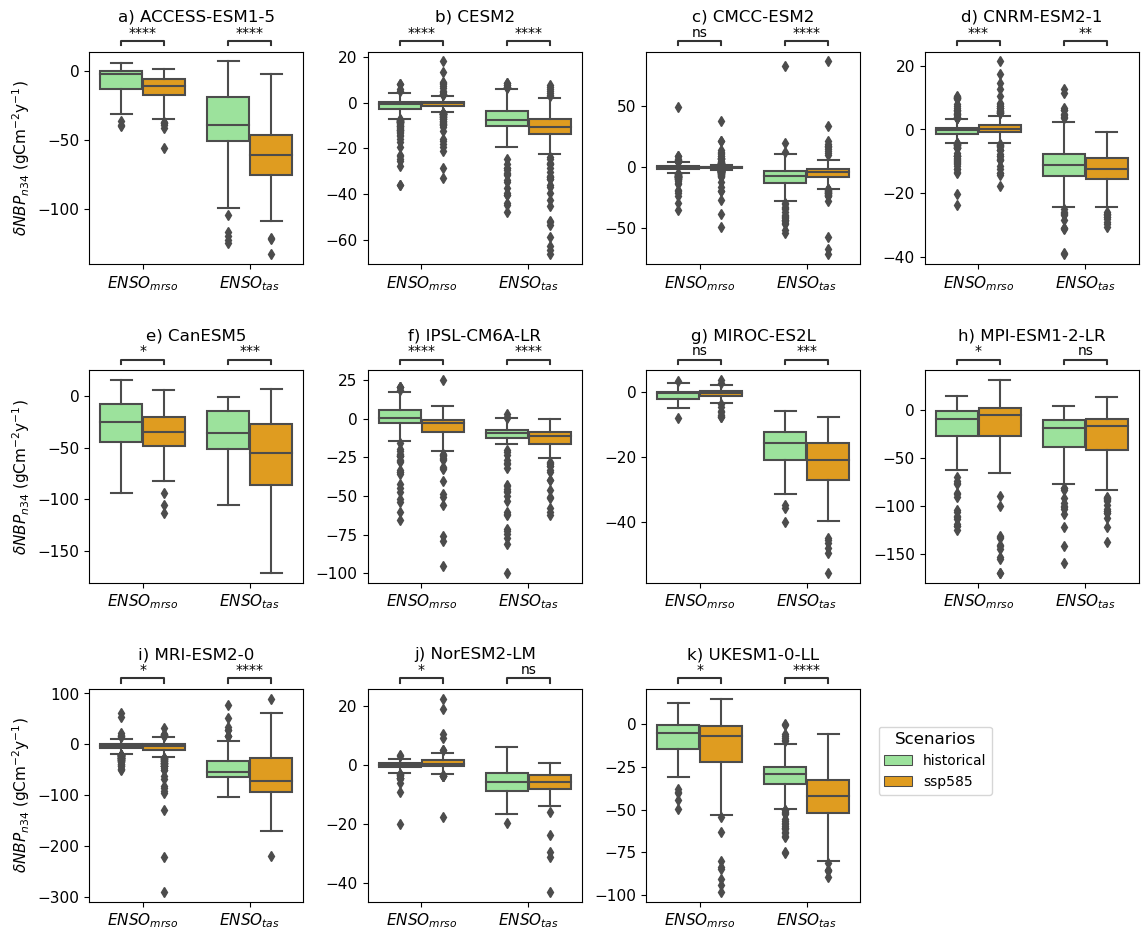

In [ ]:
import seaborn as sns
from statannot import add_stat_annotation
import seaborn.categorical

width_inch = 14
height_inch = 10

fig = plt.figure(figsize=(width_inch, height_inch))
gs = gridspec.GridSpec(3, 4)
panels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) ", "g) ", "h) ", "i) ", "j) ", "k) "]

for m, mm in enumerate(esm):
    df = Rnbp_amz[mm]
    df = df.loc[(df["variable"] == "nbp_mrso") | (df["variable"] == "nbp_tas")]

    if m < 4:
        axs = fig.add_subplot(gs[0, m])  # First row
    elif 4 <= m < 8:
        axs = fig.add_subplot(gs[1, m-4])  # Second row
    else:
        axs = fig.add_subplot(gs[2, m-8])  # Third row

    axs = sns.boxplot(data=df, x='variable', y='value', hue='scenario', palette=['lightgreen', 'orange'])

    axs.legend_.remove()
    axs.set_xlabel("")
    axs.set_xticklabels(labels=["$dNBP_{n34,mrso}$", "$dNBP_{n34,T}$"])
    axs.tick_params(labelsize=11)
    axs.set_title(panels[m] + esm[m], y=1.1)

    if m == 0 or m == 4:
        axs.set_ylabel("$\delta NBP_{n34}$ (gCm$^{-2}$y$^{-1}$)", fontsize=11)
    elif m == 8:
        axs.set_ylabel("$\delta NBP_{n34}$ (gCm$^{-2}$y$^{-1}$)", fontsize=11)
        axs.legend(loc='upper right', bbox_to_anchor=(3.5, 0.5), fontsize=10)
    else:
        axs.set_ylabel("")

    add_stat_annotation(axs, data=df, x='variable', y='value', hue='scenario',
                        box_pairs=[(("nbp_tas", "hist"), ("nbp_tas", "ssp"))],
                        test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = "bonferroni", verbose=2)

    add_stat_annotation(axs, data=df, x='variable', y='value', hue='scenario',
                        box_pairs=[(("nbp_mrso", "hist"), ("nbp_mrso", "ssp"))],
                        test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = "bonferroni", verbose=2)

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.15, right=0.9, wspace=0.3, hspace=0.5)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, ["historical", "ssp585"], loc="lower right", fontsize=10, title="Scenarios", title_fontsize=12, bbox_to_anchor = (.8, .2))

title = "dNBP_dN34_boxplot"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)
fig.savefig(os.path.join(out_path, title + ".pdf"), bbox_inches='tight', dpi = 400)

plt.show()
plt.close()        

## Multimodel Mean

In [ ]:
import xesmf as xe

def lon180(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

Rnbp_tas_hist = [lon180(a) for a in Rnbp_tas_hist]
Rnbp_tas_ssp = [lon180(a) for a in Rnbp_tas_ssp]

Rnbp_mrso_hist = [lon180(a) for a in Rnbp_mrso_hist]
Rnbp_mrso_ssp = [lon180(a) for a in Rnbp_mrso_ssp]

In [ ]:
ds_out = xe.util.cf_grid_2d(-100, -20, 1, -30, 30, 1)
regrid = [xe.Regridder(a, ds_out, "bilinear") for a in Rnbp_tas_hist]

Rnbp_tas_hist_mm = [reg(a, keep_attrs=True) for reg,a in zip(regrid, Rnbp_tas_hist)]
Rnbp_tas_ssp_mm = [reg(a, keep_attrs=True) for reg,a in zip(regrid, Rnbp_tas_ssp)]

Rnbp_mrso_hist_mm = [reg(a, keep_attrs=True) for reg,a in zip(regrid, Rnbp_mrso_hist)]
Rnbp_mrso_ssp_mm = [reg(a, keep_attrs=True) for reg,a in zip(regrid, Rnbp_mrso_ssp)]

In [ ]:
Rnbp_tas_hist_mm = xr.concat(Rnbp_tas_hist_mm, dim = "esm", coords = "minimal", compat = "override").mean(dim = "esm")
Rnbp_tas_ssp_mm = xr.concat(Rnbp_tas_ssp_mm, dim = "esm", coords = "minimal", compat = "override").mean(dim = "esm")
Rnbp_mrso_hist_mm = xr.concat(Rnbp_mrso_hist_mm, dim = "esm").mean(dim = "esm")
Rnbp_mrso_ssp_mm = xr.concat(Rnbp_mrso_ssp_mm, dim = "esm").mean(dim = "esm")

In [ ]:

content1 = mask_shape(Rnbp_tas_hist_mm, geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_tas")["nbp_tas"].reset_index().drop(columns = ["lon", "lat"])
content2 = mask_shape(Rnbp_mrso_hist_mm, geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_mrso")["nbp_mrso"].reset_index().drop(columns = ["lon", "lat"])
final = pd.concat([content1,content2], axis = 1)

content1 = mask_shape(Rnbp_tas_ssp_mm, geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_tas")["nbp_tas"].reset_index().drop(columns = ["lon", "lat"])
content2 = mask_shape(Rnbp_mrso_ssp_mm, geodf).sel(region = 1).stack(cell=["lon", "lat"]).dropna(dim='cell').to_dataframe(name = "nbp_mrso")["nbp_mrso"].reset_index().drop(columns = ["lon", "lat"])
final1 = pd.concat([content1,content2], axis = 1)

final = pd.melt(final); final["scenario"] = "hist"
final1 = pd.melt(final1); final1["scenario"] = "ssp"
Rnbp_amz_mm = pd.concat([final,final1], axis = 0)
Rnbp_amz_mm = Rnbp_amz_mm.reset_index(drop=True)

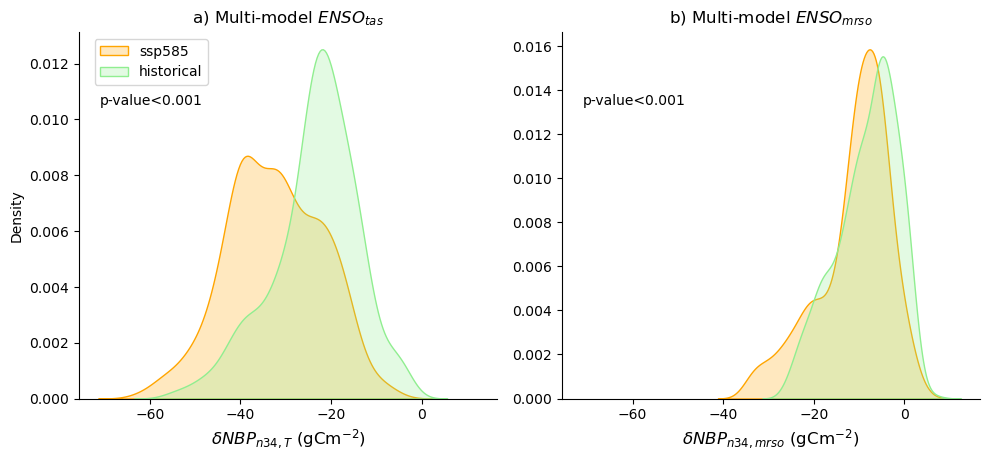

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Customize colors for the KDE plots
# custom_palette = {"hist": "blue", "ssp": "orange"}  # Define your colors for each scenario

# Plot KDE distributions
g = sns.displot(
    data=Rnbp_amz_mm, 
    x='value', 
    hue='scenario', 
    col='variable', 
    kind='kde',
    palette = ["lightgreen", "orange"],
    fill=True,  # Fills the area under the curve
    # palette=custom_palette,  # Use the custom color palette
    facet_kws={'sharey': False},  # Allows different y-scales for each facet
    legend = False
)


# Test of distribution
for ax, var in zip(g.axes.flat, ["nbp_tas", "nbp_mrso"]):
    # add_stat_annotation(ax, data=Rnbp_amz_mm, x='variable', y='value', hue='scenario',
    #                 box_pairs=[((var, "hist"), (var, "ssp"))],
    #                 test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = "bonferroni", verbose=10)
    ax.text(.05, .8, 'p-value<0.001', transform=ax.transAxes, color = "black", fontsize = 10)

# Modify the x-axis labels for each subplot
for ax, xlabel in zip(g.axes.flat, ["$\delta NBP_{n34,T}$ (gCm$^{-2}$)", "$\delta NBP_{n34,mrso}$ (gCm$^{-2}$)"]):
    ax.set_xlabel(xlabel, fontsize=12)  # Set individual x-axis labels with custom text and font size

# Modify subtitles (panel titles) for each variable
for ax, title in zip(g.axes.flat, ["a) Multi-model $ENSO_{tas}$", "b) Multi-model $ENSO_{mrso}$"]):
    ax.set_title(title, fontsize=12)  # Customize the title font size

# Optionally adjust spacing between subplots and the overall plot
g.fig.subplots_adjust(top=0.85)  # Adjust spacing above the subplots
# g.fig.suptitle("Kernel Density Estimation by Scenario", fontsize=14)  # Add a main title
g.fig.legend(["ssp585", "historical"], bbox_to_anchor = [0.12,-0.15,0.1,1])
# Show the customized plot
plt.show()

title = "dNBP_dN34_MM"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)
fig.savefig(os.path.join(out_path, title + ".pdf"), bbox_inches='tight', dpi = 400)
